In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Read Data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

2024-07-09 20:31:19.947501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Cleaning
df = df.dropna()
df = df[df['tenure'] > 0]  # Remove rows with 0 tenure

# Encoding Categorical Variables
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [3]:
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
le_churn = LabelEncoder()
df['Churn'] = le_churn.fit_transform(df['Churn'])


In [4]:
# OneHotEncoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Feature Engineering
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype(float)
df['MonthlyCharges'] = df['MonthlyCharges'].astype(float)

In [5]:
# Feature Scaling
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [6]:
# Splitting Data
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

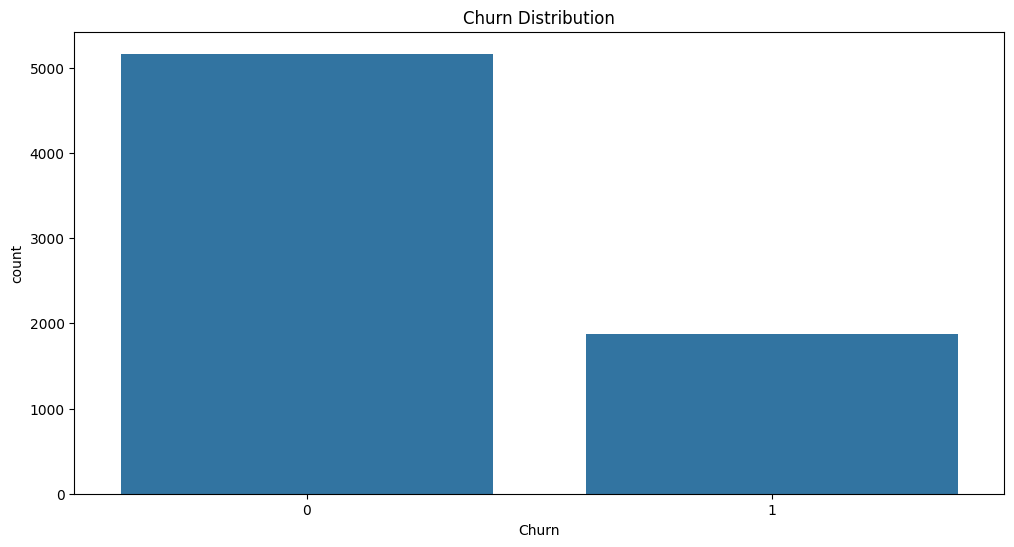

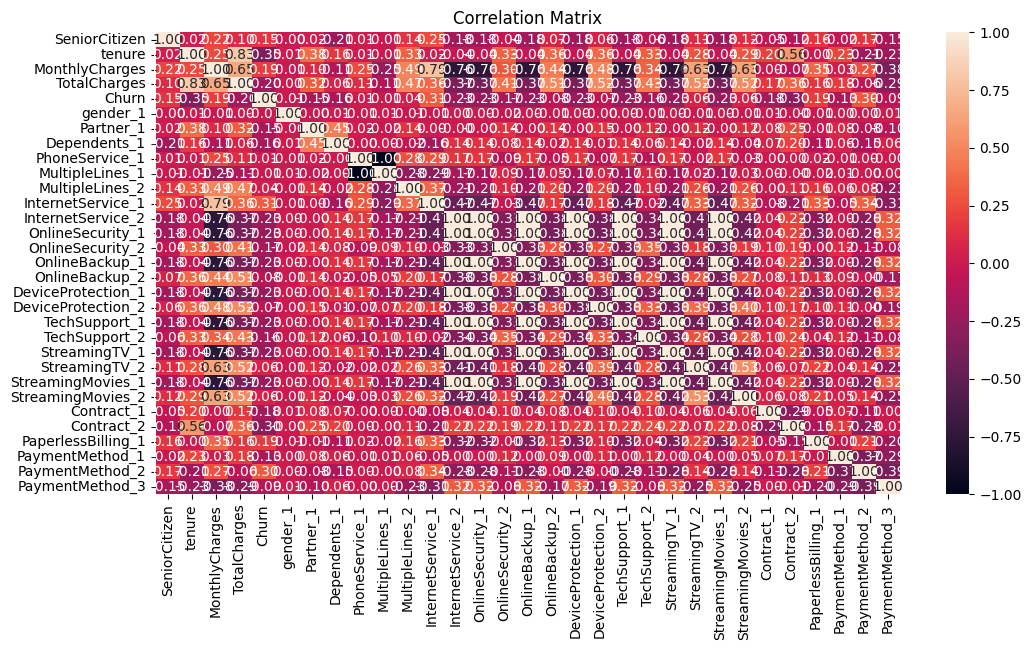

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
df_cleaned = df.drop(['customerID'], axis=1)
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df_cleaned.corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Base Model: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Confusion Matrix:
[[917 116]
 [159 215]]


In [9]:
# Random Forest with RFE
from sklearn.feature_selection import RFE
rf = RandomForestClassifier()
rfe = RFE(rf, n_features_to_select=10)
rfe.fit(X_train, y_train)
y_pred_rfe = rfe.predict(X_test)
print("Random Forest with RFE Classification Report:")
print(classification_report(y_test, y_pred_rfe))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfe))

Random Forest with RFE Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.69      1407
weighted avg       0.76      0.77      0.77      1407

Confusion Matrix:
[[901 132]
 [187 187]]


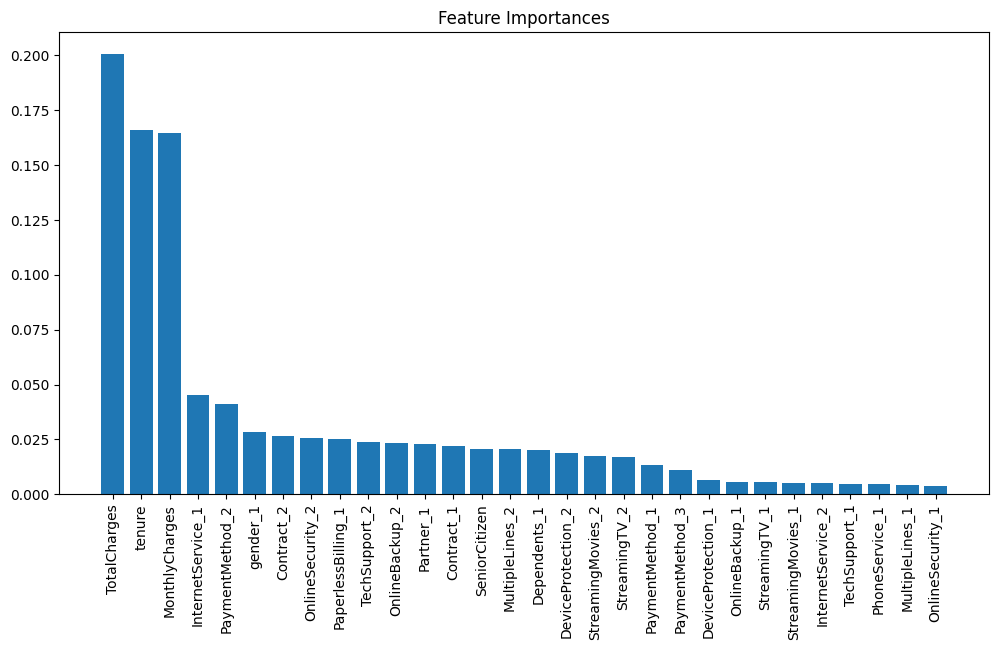

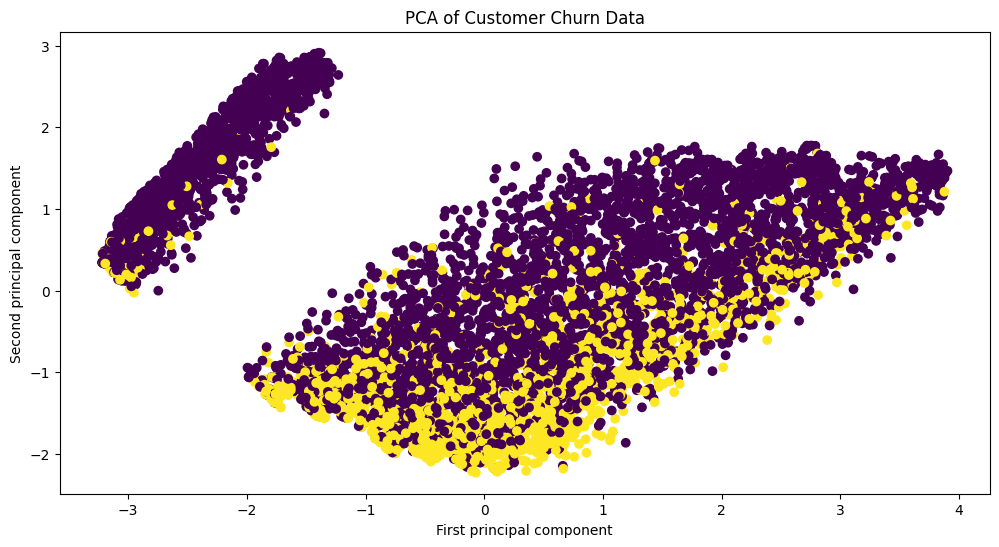

Logistic Regression with Class Weight Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

Confusion Matrix:
[[724 309]
 [ 77 297]]


In [10]:
# Feature Importance
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.show()

# Principal Component Analysis (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title("PCA of Customer Churn Data")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

# Handling Class Imbalance: Class Weight
logreg_balanced = LogisticRegression(class_weight='balanced')
logreg_balanced.fit(X_train, y_train)
y_pred_logreg_balanced = logreg_balanced.predict(X_test)
print("Logistic Regression with Class Weight Classification Report:")
print(classification_report(y_test, y_pred_logreg_balanced))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg_balanced))

In [11]:
# Handling Class Imbalance: SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
logreg_smote = LogisticRegression()
logreg_smote.fit(X_train_smote, y_train_smote)
y_pred_logreg_smote = logreg_smote.predict(X_test)
print("Logistic Regression with SMOTE Classification Report:")
print(classification_report(y_test, y_pred_logreg_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg_smote))

Logistic Regression with SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.73      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407

Confusion Matrix:
[[778 255]
 [100 274]]


In [12]:
# Model Building: Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Model Building: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Model Building: Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

# Model Building: XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Hyperparameter Tuning
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'max_iter': [100, 200, 500, 1000],
            'class_weight': [None, 'balanced']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20, None],
            'class_weight': [None, 'balanced']
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'class_weight': [None, 'balanced']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'class_weight': [None, 'balanced']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 11, 19],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(0, -9, num=100)
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 7],
            'n_estimators': [50, 100, 200],
        }
    }
}

best_params = {}

for model_name, model_details in models.items():
    print(f"Hyperparameter tuning for {model_name}...")
    clf = GridSearchCV(model_details['model'], model_details['params'], cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    best_params[model_name] = clf.best_params_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

# Model Evaluation and Comparison
models_to_evaluate = {
    'Logistic Regression': LogisticRegression(**best_params['LogisticRegression']),
    'Random Forest': RandomForestClassifier(**best_params['RandomForestClassifier']),
    'SVC': SVC(**best_params['SVC']),
    'Decision Tree': DecisionTreeClassifier(**best_params['DecisionTreeClassifier']),
    'KNeighbors': KNeighborsClassifier(**best_params['KNeighborsClassifier']),
    'GaussianNB': GaussianNB(**best_params['GaussianNB']),
    'XGBClassifier': XGBClassifier(**best_params['XGBClassifier'])
}

for model_name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(**best_params['RandomForestClassifier'])),
    ('svc', SVC(**best_params['SVC']))
]

stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stack))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1033
           1       0.46      0.47      0.46       374

    accuracy                           0.71      1407
   macro avg       0.63      0.63      0.63      1407
weighted avg       0.71      0.71      0.71      1407

Confusion Matrix:
[[824 209]
 [199 175]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
[[925 108]
 [186 188]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.53      0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Best parameters for LogisticRegression: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Hyperparameter tuning for RandomForestClassifier...
Best parameters for RandomForestClassifier: {'class_weight': None, 'max_depth': 10, 'n_estimators': 200}
Hyperparameter tuning for SVC...
Best parameters for SVC: {'C': 1, 'class_weight': None, 'kernel': 'rbf'}
Hyperparameter tuning for DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier: {'class_weight': None, 'max_depth': 5, 'min_samples_split': 10}
Hyperparameter tuning for KNeighborsClassifier...
Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'weights': 'uniform'}
Hyperparameter tuning for GaussianNB...
Best parameters for GaussianNB: {'var_smoothing': 1.0}
Hyperparameter tuning for XGBClassifier...
Best parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Logistic Regression Classification Report:
              preci

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network Model
nn_model = Sequential()
nn_model.add(Input(shape=(X_train_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(32)

# Training
nn_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Model Interpretation and Visualization
plt.figure(figsize=(12, 6))
for model_name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')

# Add the neural network model to the ROC Curve plot
nn_y_pred_prob = nn_model.predict(val_dataset).flatten()
fpr, tpr, _ = roc_curve(y_test, nn_y_pred_prob)
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for model_name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {auc(recall, precision):.2f})')

# Add the neural network model to the Precision-Recall Curve plot
precision, recall, _ = precision_recall_curve(y_test, nn_y_pred_prob)
plt.plot(recall, precision, label=f'Neural Network (AUC = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Epoch 1/10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Example usage:
title = "Learning Curves (Random Forest)"
estimator = RandomForestClassifier()  # Replace with your classifier
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()
